---
# Tarefa de treinamento: classificação de ECG
---
## Tarefas básicas
- Implementar um modelo de classificação;
- Treinar o modelo com dados de treinamento;
- Avaliar seu desempenho com dados de validação.
O que foi fornecido: esqueleto de código para a implementação de um modelo simples de rede neural de convolução.

As etapas necessárias para implementar este modelo são apresentadas como tarefas numeradas abaixo. No total, foram 6 tarefas de codificação e 3 tarefas de explicação.

### Aceleração por GPU
Para poder usar as GPUs fornecidas pelo Google Colab para acelerar seus cálculos, verifique se o `Acelerador de hardware` está definido como `GPU` em `Tempo de execução > Alterar tipo de tempo de execução`. Observe que os notebooks são executados conectando-se a máquinas virtuais (virtual machines - VMs) com vida útil máxima de até 12 horas. Os notebooks também se desconectam das VMs quando ficam ociosos por muito tempo.

In [1]:
# Verifica se o arquivo requisitos.txt já existe: se existe, não mexe em nada; se não, precisa ser criado!

import os #Importa o módulo padrão os do Python, que contém funções para interagir com o sistema de ficheiros, variáveis de ambiente, etc

# Definição da função Helper - validação se existe ou não o path, se está sendo usado do cachê
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} já existe. Usando cachê.')
    return val

In [2]:
# Instalar as dependências do projeto (é necessário Python 3.9 ou superior)
!pip install -r requisitos.txt

  Using cached certifi-2023.5.7-py3-none-any.whl (156 kB)
  Using cached cffi-1.15.1-cp310-cp310-win_amd64.whl (179 kB)
  Using cached charset_normalizer-3.1.0-cp310-cp310-win_amd64.whl (97 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Using cached ecg_plot-0.2.8-py3-none-any.whl (9.2 kB)
  Using cached filelock-3.12.2-py3-none-any.whl (10 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.3-cp310-cp310-win_amd64.whl (17 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached pandas-1.5.3-cp310-cp310-win_amd64.whl (10.4 MB)
  Using cached pycparser-2.21-py2.py3-none-any.whl (118 kB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached soundfile-0.12.1-py2.py3-none-win_amd64.whl (1.0 MB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
 

You should consider upgrading via the 'C:\Users\Sofia Falco\Documents\Git\Meu Git\toyproblem_af\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
# Comando específico do Jupyter/Notebook para que o gráfico apareça na célula
%matplotlib inline

---
## O banco de dados

O conjunto de dados é um subconjunto da [*base de dados CODE*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): um banco de dados anotado de ECGs. Os exames de ECG foram registrados no Brasil pela Rede de Telessaúde do estado de Minas Gerais entre 2010 e 2016. O conjunto de dados e seu uso para o desenvolvimento de métodos de aprendizado profundo foram descritos em ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
O conjunto de dados completo está disponível para pesquisa mediante solicitação.


- Para o conjunto de dados de treinamento os dados estão rotulados.
- Para o conjunto de dados de teste não há os rótulos.
- A avaliação é feita por meio do envio para a tabela de classificação.

Baixe o conjunto do link fornecido e descompacte a pasta que contém os arquivos. Os arquivos baixados estão no formato WFDB (conjunto de padrões abertos e software para armazenar e analisar sinais fisiológicos e anotações, consistindo basicamente por um ficheiro de cabeçalho .hea com metadados e um ou mais ficheiros de dados com os próprios sinais, em formato .dat geralmente). Veja [aqui](https://www.physionet.org/content/wfdb-python/3.4.1/) para detalhes.

In [7]:
# 1. Baixar o banco de dados (se for necessário)
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

codesubset.tar.gz já existe. Usando cachê.


In [9]:
# 1. Descompactando o arquivo do banco de dados (se for necessário)
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

codesubset já existe. Usando cachê.


Note que a pasta extraída 'codesubset' contém:
1. Subpastas com o traçado dos ECGs. Elas precisam ser pré-processadas posteriormente, o que será feito nas próximas etapas.
2. Um arquivo .csv que contém os rótulos e outros recursos para os dados de treinamento.


### Pré-processamento

Execute as células abaixo para flonar o repositório Github usado para [pré-processamento dos dados](https://github.com/antonior92/ecg-preprocessing).

In [12]:
# 2. Clonagem dos arquivos para processamento dos dados de ECG
if not exists('ecg-preprocessing'):
    !git clone https://github.com/sofiamafrodrigues/ecg-preprocessing.git

ecg-preprocessing já existe. Usando cachê.


Vamos plotar um exemplo de um ECG, antes de processá-lo. Nós podemos usar a biblioteca `ecg_plot` para exemplo, usando o seguinte trecho de código onde `ecg_sample` é uma matriz de tamanho `(número de derivações * comprimento da sequência)`.

<Figure size 640x480 with 0 Axes>

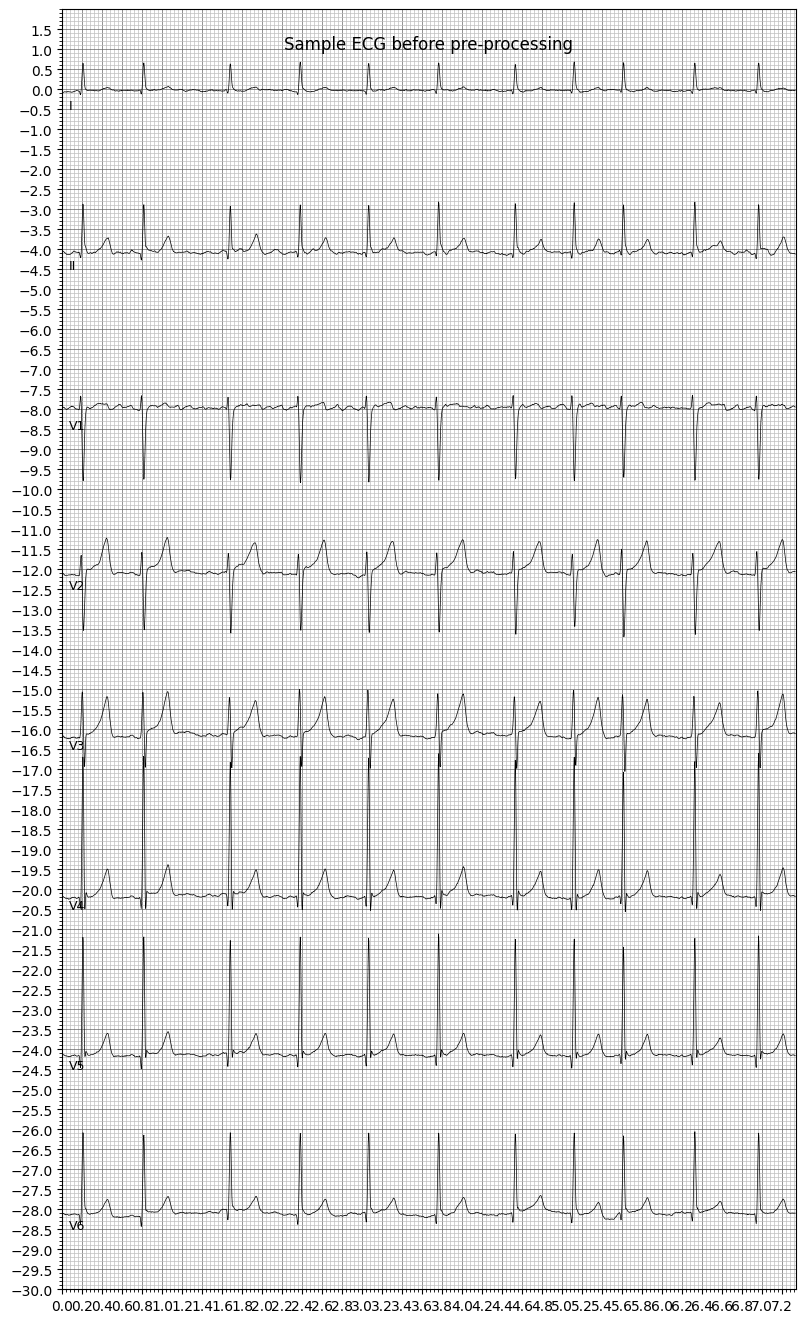

In [3]:
import ecg_plot #Biblioteca específica
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046' #Pegando o caminho do arquivo no formato WFDB
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB) #Chamando a função read_ecg, que tem como saída a amostra de ECG e a taxa de amostragem e como entrada a pasta onde está o arquivo WFDB

# Plotagem
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


O pré-processamento consiste em:
- Reamostragem de todos os traçados de ECG para 400 Hz. Opção: ``--new_freq 400``.
- Preenchimento com zeros, se necessário, para que todos os ECGs tenham o mesmo número de amostras (4096). Opção: ``--new_len 4096``.
(Há sinais que podem estar ligeiramente menores pelas diferenças entre equipamentos)
- Remoção de tendências (derivações lentas) no sinal de ECG. Opção: ``--remove_baseline``.
(O ECG contém derivações lentas, de processos como a respiração e o movimento, abaixo de 0,5 Hz, que deslocam o sinal. Por isso remover!)
- Remoção de possíveis ruídos da linha de energia. Opção: ``--remove_powerline 60``.
(Remoção de contaminações devido à interferência eletromagnética)


Namespace(path='codesubset/train/TNMG100046', save='', new_freq=400.0, new_len=4096, scale=1, use_all_leads=False, remove_baseline=True, remove_powerline=60.0, fmt='wfdb')


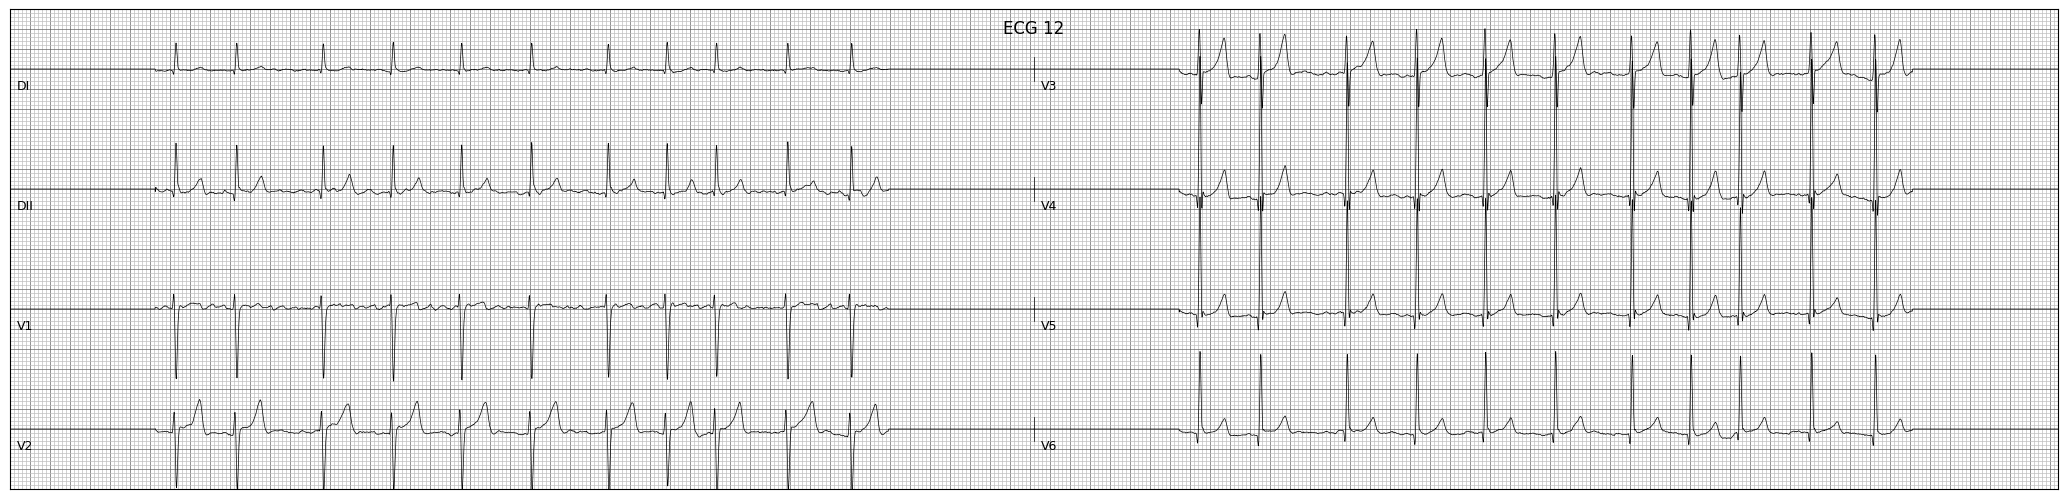

<Figure size 640x480 with 0 Axes>

In [4]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --remove_powerline 60


Em seguida, realizamos o pré-processamento em todos os exames e os convertemos em um único arquivo h5 (veja [aqui](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) para detalhes sobre o formato HDF5). O arquivo h5 resultante contém os traçados como matrizes com a forma `(número de traçados * comprimento da sequência * número de derivações)` onde o comprimento da sequência é 4096 e o número de derivações é 8.
Os arquivos `train.h5` e `test.h5` serão salvos na pasta `codesubset/`.

In [5]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --remove_powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --remove_powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(input_file='codesubset/train/RECORDS.txt', out_file='codesubset/train.h5', root_dir=None, new_freq=400.0, new_len=4096, scale=1, use_all_leads=False, remove_baseline=True, remove_powerline=60.0, fmt='wfdb')



100%|##########| 10000/10000 [16:27<00:00, 10.13it/s]


Namespace(input_file='codesubset/test/RECORDS.txt', out_file='codesubset/test.h5', root_dir=None, new_freq=400.0, new_len=4096, scale=1, use_all_leads=False, remove_baseline=True, remove_powerline=60.0, fmt='wfdb')



100%|##########| 6000/6000 [08:11<00:00, 12.21it/s]


### Tarefa de Programação 1: Análise de Dados

Antes de começar a modelar, você deve analisar o conjunto de dados. Você pode ser criativo na forma de se familiarizar com os dados. O que você deve fazer é:
- Plotar um ECG após o pré-processamento salvo no arquivo HDF5. Para isto, use o exemplo de ecg_plot() mostrado acima e acesse os dados pré-processados assim:
```
import h5py
PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
`data[i]` é um arranjo Numpy do $i$-ésimo exame de ECG (incluindo todos os pontos no tempo e todas as derivações).

Algumas outras ideias para explorar:
- Checar o balanceamento do conjunto de dados;
- Avaliar a distribuição de idade e sexo dos pacientes;
- Pensar sobre a performance que um classificador ingênuo (best naive classifier) teria, por exemplo adivinhando aleatoriamente ou sempre prevendo uma mesma classe.


<Figure size 1000x1200 with 0 Axes>

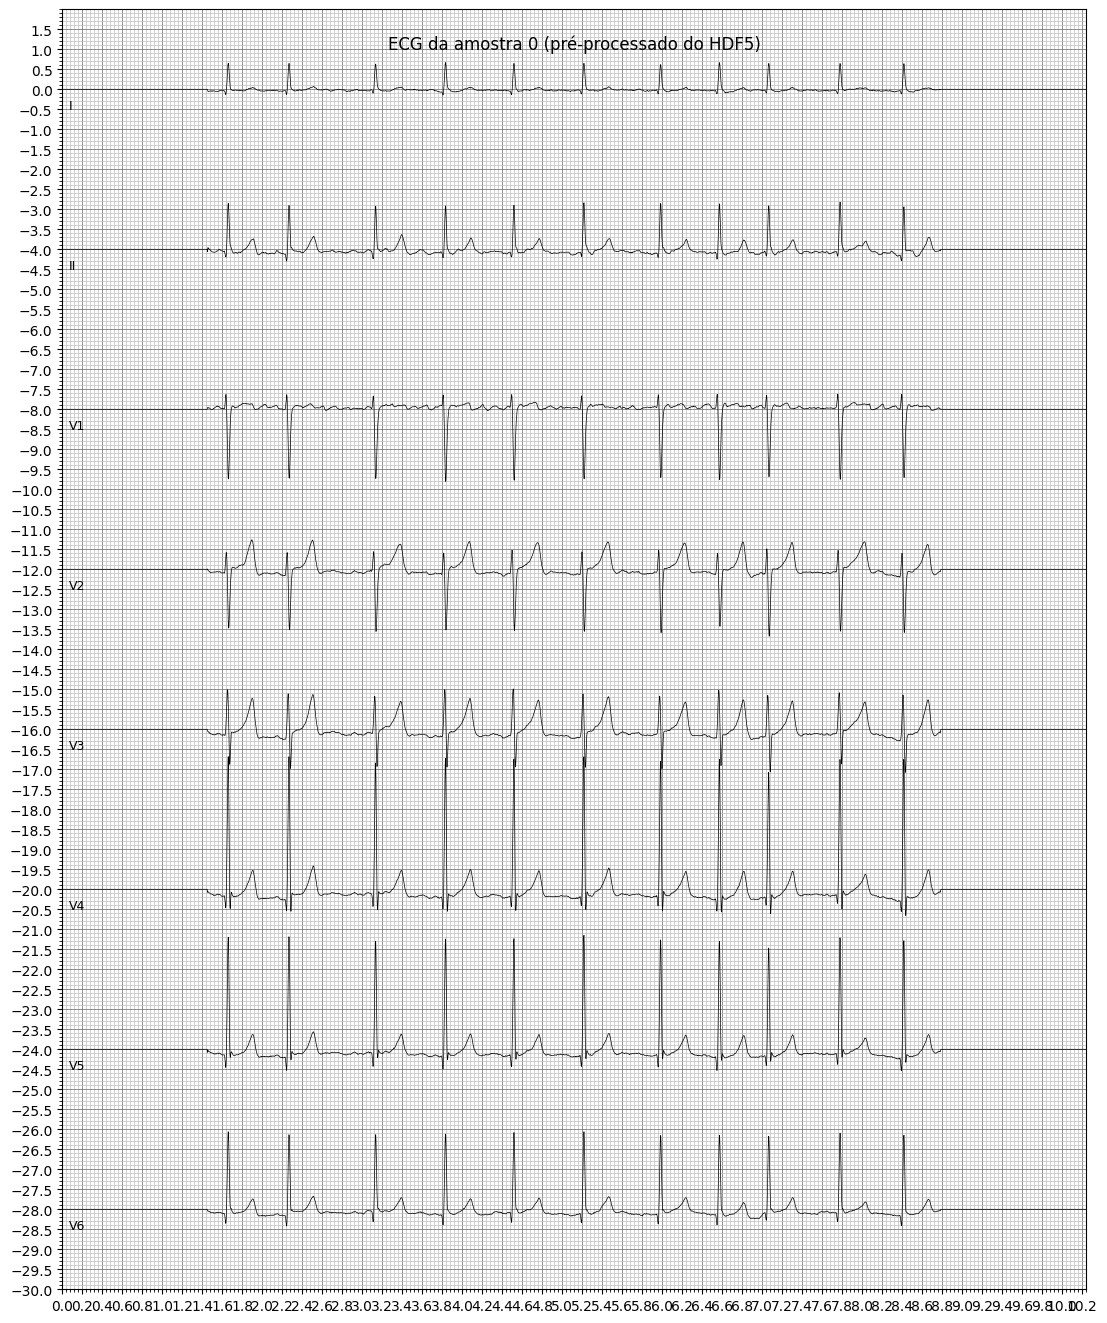

In [8]:
# 1. Plotagem no formato HDF5

import h5py
import matplotlib.pyplot as plt
import ecg_plot #Função específica
PATH_TO_H5_FILE = 'codesubset/train.h5' #Caminho do arquivo HDF5
f = h5py.File(PATH_TO_H5_FILE, 'r') #Criação de dicionário Python: abre o arquivo HDF5 usando a biblioteca h5py
data = f['tracings'] #Acessa o dataset tracings (traçados) e cria uma view para os dados em disco (objeto pode ser acessado array Numpy)

sample_rate = 400
lead_names = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

i = 0  #Índice da amostra que selecionei
ecg_sample = data[i]  # isso retorna um numpy array (seq_len x num_leads)

plt.figure(figsize=(10, 12))
ecg_plot.plot(
    ecg_sample.T,  #Transpor para ficar leads versus time
    sample_rate=sample_rate,
    style='bw',
    row_height=8,
    lead_index=lead_names,
    columns=1,
    title=f'ECG da amostra {i} (pré-processado do HDF5)'
)
plt.show()

### Explicação da tarefa 1: Análise de Dados

1. Plotagem formato HDF5:
Utilizou-se a função ecg_plot() e acessou-se a amostra 0, a mesma do formato WFDB porém agora pré-processada. Deixo abaixo um resumo do porquê transformar os dados para o formato HDF5:

WFDB: cada exame é salvo em arquivos separados (formatos variados como dat, hea, entre outros); lidar com arquivos pequenos (vários) gera overbead de leitura (I/O lento); cada exame pode ter diferentes taxas de amostragem, quantidade de amostras e até n° diferente de derivações, tornando mais difícil padronizar; carregar e explorar os dados em lote para treinamento de redes neurais torna-se mais complicado.

Vantagens do HDF5: armazena todos os exames em um único arquivo (ou em um de treino e um de teste); suporta arrays multidimensionais gigantes; permite acesso eficiente a pedaços dos dados, sem carregar todo o arquivo em memória; os sinais podem ser armazenados já pré-processados; formato portável e padronizado para Python, MATLAB, R; com a biblioteca h5py dá para tratar o dataset como se fosse um array Numpy gigante em disco.

<br />

--- ANÁLISE DO CONJUNTO DE TREINAMENTO (codesubset/train.csv) ---
Quantidade Total de Exames: 10000



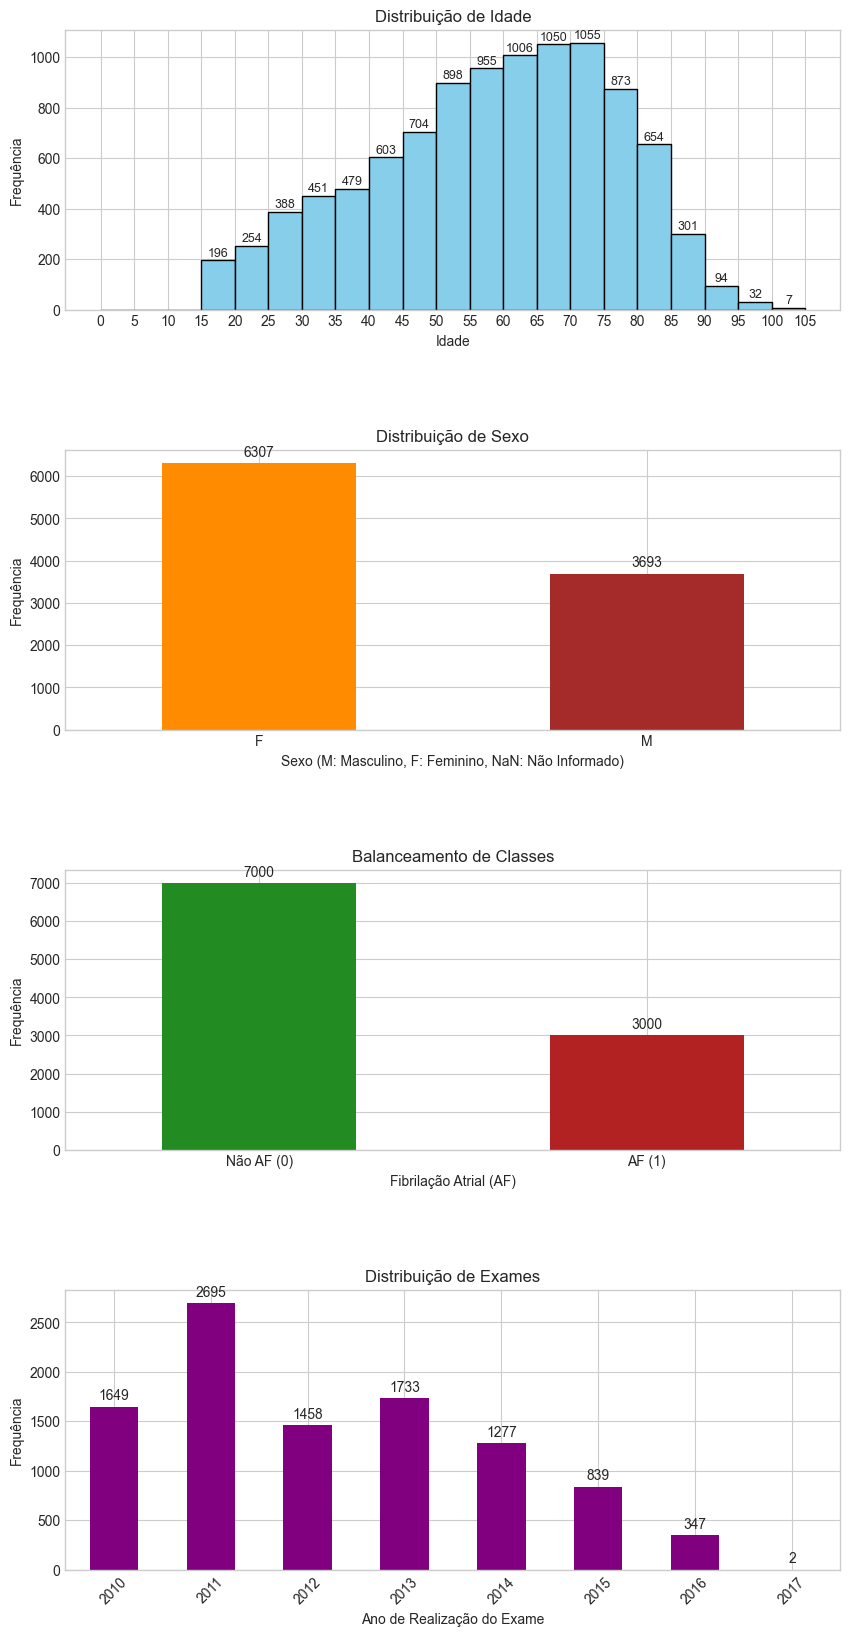

In [15]:
# 2. Checando o balanceamento do conjunto de dados
# 3. Avaliação da distribuição de idade e sexo dos pacientes

import pandas as pd
import matplotlib.pyplot as plt
import os

PATH_TO_CSV_FILE = 'codesubset/train.csv' #Assume que o script está sendo executado a partir do diretório correto

if not os.path.exists(PATH_TO_CSV_FILE): #Verifica se o arquivo existe antes de tentar carregar
    print(f"ERRO: Arquivo não encontrado em: {PATH_TO_CSV_FILE}")
    print("Certifique-se de que a pasta 'codesubset' e o arquivo 'train.csv' existem no caminho correto.")
else:
    #Carregamento e Visão Geral dos Dados
    try:
        #Tenta carregar o arquivo CSV
        df = pd.read_csv(PATH_TO_CSV_FILE)
        
        #Quantidade total de exames
        total_exames = df.shape[0]
        print(f"--- ANÁLISE DO CONJUNTO DE TREINAMENTO ({PATH_TO_CSV_FILE}) ---")
        print(f"Quantidade Total de Exames: {total_exames}\n")

        #Configurações para os gráficos
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(4, 1, figsize=(10, 20))
        plt.subplots_adjust(hspace=0.5) # Ajusta o espaçamento entre os subplots
        
        #Histograma de Distribuição de Idades (em intervalos de 5 anos)
        max_age = int(df['age'].max() // 5 + 1) * 5
        bins = range(0, max_age + 5, 5)
        
        n, bins_edges, patches = axes[0].hist(df['age'].dropna(), bins=bins, edgecolor='black', color='skyblue')
        
        #Lógica de anotação para o Histograma de Idade
        for i, count in enumerate(n):
            if count > 0: #Anota apenas se houver valores no bin
                # Calcula a posição central da barra (média das bordas do bin)
                center_x = (bins_edges[i] + bins_edges[i+1]) / 2
                axes[0].text(center_x, count + 5, int(count), ha='center', va='bottom', fontsize=9)
                
        axes[0].set_title('Distribuição de Idade')
        axes[0].set_xlabel('Idade')
        axes[0].set_ylabel('Frequência')
        axes[0].set_xticks(bins) # Define os rótulos do eixo X nos limites dos bins

        #Histograma de Sexo dos Pacientes
        sex_counts = df['sex'].value_counts(dropna=False)
        bars_sex = sex_counts.plot(kind='bar', ax=axes[1], color=['darkorange', 'brown', 'gray'])
        axes[1].bar_label(bars_sex.containers[0], padding=3) 
        axes[1].set_title('Distribuição de Sexo')
        axes[1].set_xlabel('Sexo (M: Masculino, F: Feminino, NaN: Não Informado)')
        axes[1].set_ylabel('Frequência')
        axes[1].tick_params(axis='x', rotation=0) # Mantém os rótulos na horizontal

        #Histograma de Presença de Fibrilação Atrial (AF)
        af_counts = df['AF'].value_counts(dropna=False)
        af_counts.index = af_counts.index.map({0.0: 'Não AF (0)', 1.0: 'AF (1)', pd.NA: 'Não Informado'})
        bars_af = af_counts.plot(kind='bar', ax=axes[2], color=['forestgreen', 'firebrick', 'gray'])
        axes[2].bar_label(bars_af.containers[0], padding=3)
        axes[2].set_title('Balanceamento de Classes')
        axes[2].set_xlabel('Fibrilação Atrial (AF)')
        axes[2].set_ylabel('Frequência')
        axes[2].tick_params(axis='x', rotation=0)

        #Histograma da Data de Realização do Exame (por ano)
        df['year'] = pd.to_datetime(df['date_exam'], format='%Y-%m-%d', errors='coerce').dt.year #Converte a coluna para datetime e extrai o ano
        
        year_counts = df['year'].value_counts().sort_index()
        bars_year = year_counts.plot(kind='bar', ax=axes[3], color='purple')
        axes[3].bar_label(bars_year.containers[0], padding=3)
        axes[3].set_title('Distribuição de Exames')
        axes[3].set_xlabel('Ano de Realização do Exame')
        axes[3].set_ylabel('Frequência')
        axes[3].tick_params(axis='x', rotation=45)

        #Exibe todos os gráficos
        plt.show()

    except Exception as e:
        print(f"\nOcorreu um erro ao processar o arquivo CSV: {e}")
        print("Verifique se as colunas 'age', 'sex', 'AF' e 'date_exam' estão presentes no arquivo.")

In [2]:
# 4. Naive classifiers (classificadores de baseline)

import h5py, numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             precision_recall_fscore_support, confusion_matrix,
                             roc_auc_score)
import random

#Criação da semente
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

#Carregando os dados
PATH = 'codesubset/train.h5'
if not os.path.exists(PATH): #Verifica se o arquivo existe antes de tentar carregar
    print(f"ERRO: Arquivo não encontrado em: {PATH}")
    print("Certifique-se de que a pasta 'codesubset' e o arquivo 'train.h5' existem no caminho correto.")
else:
    with h5py.File(PATH, 'r') as f:
        X = f['tracings'][:]   #Formato (N, seq_len, n_leads)
        y = f['labels'][:]     #Assume que train.h5 contém 'labels'; ajuste caso contrário
    
    print("X shape:", X.shape, "y shape:", y.shape)
    
    #Extração de características: flatten simples (nivelamento de dados) + opcional PCA (análise componente principal)
    N, L, C = X.shape #Desempacotando a tupla
    X_flat = X.reshape(N, L*C) # Atenção: dimensão grande (p.ex. 4096*8 = 32768)
    pca = PCA(n_components=200, random_state=SEED) #Opcional: reduzir dimensão com PCA antes do GaussianNB (ex.: 200 componentes)
    X_pca = pca.fit_transform(X_flat)
    
    #Divisão do dataset de forma estratificada (treino/validação)
    X_tr, X_val, y_tr, y_val = train_test_split(X_pca, y, test_size=0.2,
                                                stratify=y, random_state=SEED)
    
    #Padronização
    scaler = StandardScaler().fit(X_tr) #Média e dev pad do conjunto de treino
    X_tr_s = scaler.transform(X_tr) #Aplica a padronização no conjunto de cada feature, parte do treinamento (cada feature fica com média aproximadamente 0 e dev pad aproximadamente 1, deixando tudo na mesma escala)
    X_val_s = scaler.transform(X_val) #Mesma padronização, conjunto de validação
    
# -------------------------------------------------------------------------------------------------------------------
    # 4.1: Classificador majoritário
    dummy_major = DummyClassifier(strategy='most_frequent') #Criando a instância do classificador
    dummy_major.fit(X_tr_s, y_tr) #Ajusta o modelo com os dados de treinamento
    y_pred_major = dummy_major.predict(X_val_s) #Faz as previsões no conjunto de validação
    
    # 4.2: Classificador aleatório
    dummy_rand = DummyClassifier(strategy='stratified', random_state=SEED) #Criando a instância do classificador, que segue a tendência dos dados (não totalmente randômico, respeita sua distribuição)
    dummy_rand.fit(X_tr_s, y_tr) #Ajusta o modelo com os dados de treinamento
    y_pred_rand = dummy_rand.predict(X_val_s) #Faz as previsões no conjunto de validação
    
    # 4.3: GaussianNB
    gnb = GaussianNB() #Criando a instância do classificador
    gnb.fit(X_tr_s, y_tr) #Ajusta o modelo com os dados de treinamento
    y_pred_gnb = gnb.predict(X_val_s) #Faz as previsões no conjunto de validação
    y_proba_gnb = gnb.predict_proba(X_val_s) if hasattr(gnb, 'predict_proba') else None #If é somente segurança para que esteja + genérico

#---------------------------------------------------------------------------------------------------------------------    
    #Métricas de avaliação
    def print_metrics(y_true, y_pred, y_proba=None):
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Balanced accuracy:", balanced_accuracy_score(y_true, y_pred))
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
        print("Precision (macro): {:.3f}, Recall (macro): {:.3f}, F1 (macro): {:.3f}".format(p, r, f1))
        print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
        if y_proba is not None:
            # exemplificativo: multiclass ROC-AUC macro
            try:
                from sklearn.preprocessing import label_binarize
                classes = np.unique(y_true)
                y_bin = label_binarize(y_true, classes=classes)
                auc = roc_auc_score(y_bin, y_proba, average='macro', multi_class='ovr')
                print("ROC-AUC (macro, ovr):", auc)
            except Exception as e:
                pass
    
    print("=== Classificador majoritário ===")
    print_metrics(y_val, y_pred_major)
    
    print("\n=== Classificador aleatório ===")
    print_metrics(y_val, y_pred_rand)
    
    print("\n=== GaussianNB ===")
    print_metrics(y_val, y_pred_gnb, y_proba_gnb)

KeyError: "Unable to open object (object 'labels' doesn't exist)"

### Explicação da tarefa 1: Analise de Dados

4. Naive classifiers (classificadores de baseline):
Optei por implementar 3 modelos distintos, considerados como classificadores naive, sendo  e o GaussianNB.
4.1 Classificador majoritário
xxx
4.2 Classificador aleatório
xx
4.3 GaussianNB
xxx

<br />

---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [ ]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [ ]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()

    def forward(x):
        return

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [ ]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [ ]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**


In [19]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-2
weight_decay = 1e-1
num_epochs = 15
batch_size = 32

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

In [ ]:
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = ModelBaseline()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = None

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""